In [1]:
import time
import dask.dataframe as dd
from dask.distributed import Client
from config import *
import simpler_pandas
import numpy as np

import matplotlib.pyplot as plt
import simpler_mpl


%load_ext autoreload
%autoreload 2

In [2]:
if 'client' not in dir():
    client = Client(n_workers=4, threads_per_worker=1, processes=True, memory_limit='6GB')
    print(client)

DATA = DATA_PARQUET_10_SNAPPY 
ddf = dd.read_parquet(DATA)
ddf.dtypes

/home/ian/miniconda3/envs/pydata2020global/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41841 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:42033' processes=4 threads=4, memory=24.00 GB>


tin                 object
price                int64
date        datetime64[ns]
postcode            object
pt                  object
new                 object
duration            object
paon                object
saon                object
street              object
locality            object
town                object
district            object
county              object
ppd_cat             object
status              object
dtype: object

In [3]:
df = ddf.compute()
df.shape

(25467513, 16)

In [11]:
np.logspace?

In [82]:
import pandas as pd

all_nrows = [int(n) for n in np.logspace(1, 8, num=8)]
print(all_nrows)
timings = []
for nrows in all_nrows:
    for n_sample in range(2):
        dfs = df[:nrows]
        dfs.to_parquet('/tmp/out.parquet')
        t1 = time.time()
        dfs2 = pd.read_parquet('/tmp/out.parquet')
        print(dfs2.shape)
        delta = time.time() - t1
        timings.append((nrows, delta))


[10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
(10, 16)
(10, 16)
(100, 16)
(100, 16)
(1000, 16)
(1000, 16)
(10000, 16)
(10000, 16)
(100000, 16)
(100000, 16)
(1000000, 16)
(1000000, 16)
(10000000, 16)
(10000000, 16)
(25467513, 16)
(25467513, 16)


In [161]:
df_seconds_all = pd.DataFrame(timings, columns=['nrows', 'seconds'])[:-2]
df_seconds = df_seconds_all.groupby(df_seconds_all.nrows)[['seconds']].min()
df_seconds

,seconds
nrows,
10,0.005575
100,0.005785
1000,0.008117
10000,0.023356
100000,0.186751
1000000,2.070107
10000000,19.588532


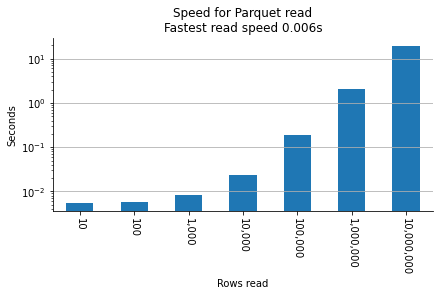

In [205]:
fig, ax = plt.subplots(constrained_layout=True)
df_seconds.plot(kind='bar', ax=ax)

min_time = float(df_seconds.min())
title = f"Speed for Parquet read\nFastest read speed {min_time:0.3f}s"
simpler_mpl.set_common_mpl_styles(ax, ylabel='Seconds', xlabel='Rows read', 
                                  title=title, legend=False, grid_axis='y')
ax.semilogy()
simpler_mpl.rotate_labels(x_axis=True)
simpler_mpl.set_commas(ax, y_axis=False, x_axis=True)

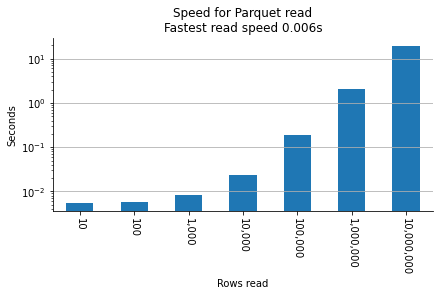

In [207]:
#pd.set_option('plotting.backend', 'matplotlib') 
df_to_plot = df_seconds.reset_index().assign(nrows=[f'{v:,}' for v in df_seconds.index])
fig, ax = plt.subplots(constrained_layout=True)
df_to_plot.set_index('nrows').plot(kind='bar', ax=ax)
min_time = float(df_seconds.min())
title = f"Speed for Parquet read\nFastest read speed {min_time:0.3f}s"
simpler_mpl.set_common_mpl_styles(ax, ylabel='Seconds', xlabel='Rows read', 
                                  title=title, legend=False, grid_axis='y')
ax.semilogy()
simpler_mpl.rotate_labels(x_axis=True)


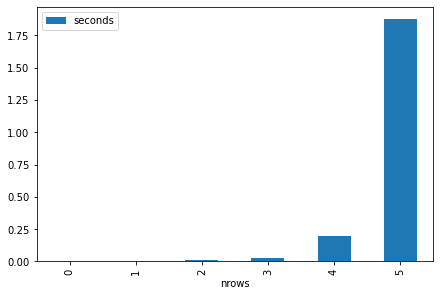

In [155]:
fig, ax = plt.subplots(constrained_layout=True)
df_seconds.plot(kind='bar', ax=ax)
#fig.draw()
#plt.draw()
import matplotlib.ticker as mtick
fmt = '{x:,}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) # works but still bad label


#simpler_mpl.set_common_mpl_styles(ax, ylabel='Seconds', xlabel='Rows read', 
#                                  title="Speed for Parquet read", legend=False, grid_axis='y')
#ax.semilogy()
#simpler_mpl.rotate_labels(x_axis=True)
#simpler_mpl.set_commas(ax, y_axis=False, x_axis=True)
#simpler_mpl.set_human_format(ax, on_y_axis=True, precision=1, trim_0_decimals=True)

#simpler_mpl.set_human_format(plt.gca(), on_x_axis=True, precision=0, prefix="", )

#plt.xticks()[1][0] # gets rendered xtick text
#t=plt.xticks()[1][0]
#import matplotlib as mpl
#plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f%%'))    
#simpler_mpl.set_commas(ax, x_axis=True)
#ax.get_xticklabels() # this works

In [168]:
import altair as alt
#pd.set_option('plotting.backend', 'altair') 

In [171]:
df_seconds

,seconds
nrows,
10,0.005575
100,0.005785
1000,0.008117
10000,0.023356
100000,0.186751
1000000,2.070107
10000000,19.588532


In [190]:
df_seconds.reset_index().assign(nrows=[f'{v:,}' for v in df_seconds.index])

,nrows,seconds
0,10,0.005575
1,100,0.005785
2,"1,000",0.008117
3,"10,000",0.023356
4,"100,000",0.186751
5,"1,000,000",2.070107
6,"10,000,000",19.588532


In [195]:
df_to_plot

,nrows,seconds
0,10,0.005575
1,100,0.005785
2,"1,000",0.008117
3,"10,000",0.023356
4,"100,000",0.186751
5,"1,000,000",2.070107
6,"10,000,000",19.588532


In [200]:
df_to_plot = df_seconds.reset_index().assign(nrows=[f'{v:,}' for v in df_seconds.index])
alt.Chart(df_to_plot).mark_bar().encode(
    x=alt.X('nrows', sort=df_to_plot.nrows.values),
    y= alt.Y('seconds', scale= alt.Scale(type= 'log')),
).properties(
    title='Parquet read times by row-count',
    width=200,
    height=200
)

alt.Chart(...)